# Toy model: quadratic function, ressembling weak-lensing power spectrum

In [2]:
from os import environ
import numpy as np
import pylab as plt

In [3]:
%matplotlib inline

### Weak-lensing power spectrum

In [4]:
basedir = '{}/astro/papers/cs_review/figures/dlogP_dlogp'.format(environ['HOME'])

In [5]:
def read_Cell(path, ell_min, ell_max):
    """Read P_kappa file and return log_10(ell), log_10(C_ell) within ell-range
    """
    
    pk = np.loadtxt(path)
    ell  = pk[:,0]
    Cell = pk[:,1] / (ell * (ell+1) / (2 * np.pi))

    ran     = (ell>=ell_min) & (ell<=ell_max)
    
    return np.log10(ell[ran]), np.log10(Cell[ran])

#### Fitting range

In [6]:
ell_min = 10
ell_max = 1e4

#### Fiducial cosmological parameters

In [7]:
Om_fid = 0.306
s8_fid = 0.827

#### Plot standard power spectrum

In [8]:
logell, logCell = read_Cell('{}/P_kappa'.format(basedir), ell_min, ell_max)

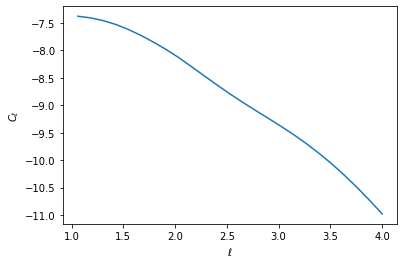

In [9]:
p = plt.plot(logell, logCell)
tx = plt.xlabel('$\ell$')
ty = plt.ylabel('$C_\ell$')

## Fitting functions
We define a quadratic function $q(u) = c + a (u - u_0)^2$, which we will fit to the (ten-)logarithm of the weak-lensing power spectrum $C_\ell$. We will then vary two parameters, that mimic cosmological parameter as follows:

1. A tilt parameter `tilt`, corresponding to the matter density $\Omega_{\rm m}$. This is linearly related to the shift $u_0$.

2. An amplitude parameter `ampl`, corresponding to the power-spectrum amplitude $\sigma_8$. The logarithm of that parameter is linearly related to the offset $c$.

In [10]:
from scipy.optimize import curve_fit

In [11]:
def add(ampl):
    """Return the additive constant of the quadratic function
       from the amplitude fitting parameter
       (mimics power-spectrum normalisation s8)
    """
    
    # This provides a best-fit amp=0.827, but the 10% increased
    # spectrum (0.9097) gives a best-fit of 0.925
    # Changing the prefactor of amp or lg(amp) does not help...
    
    c = np.log10(ampl)*2 - 6.11568527 + 0.1649
    
    return c

In [12]:
def shift(tilt):
    """Return the shift parameter of the quadratic function
       from the tilt parameter (mimics matter density)
    """
    
    u0 = tilt * 1.85132114 / 0.306
    
    return u0

In [13]:
def quadratic(u, *params):
    """Used to fit quadratic function varying all three parameters
    """
    
    (ampl, tilt, a) = np.array(params)
    c  = add(ampl)
    u0 = shift(tilt)
    
    return c + a * (u - u0)**2

In [14]:
def quadratic_c(u, *params):
    """Used to fit quadratic function varying constant coefficient only
    """
    (ampl) = np.array(params)
    c  = add(ampl)
    u0 = shift(tilt_glob)
    
    return c + a_glob * (u - u0)**2

In [15]:
def quadratic_u0(u, *params):
    """Used to fit quadratic function varying shift parameter only
    """
    (tilt) = np.array(params)
    c = add(ampl_glob)
    u0 = shift(tilt)
    
    return c + a_glob * (u - u0)**2

## Fitting

### Fit standard power spectrum

In [16]:
p0 = [1, 0, 0]
popt, pcov = curve_fit(quadratic, logell, logCell + logell, p0)

Best-fit parameter (ampl, tilt, $u_0$)

In [17]:
popt

array([ 0.82708472,  0.306     , -0.17586216])

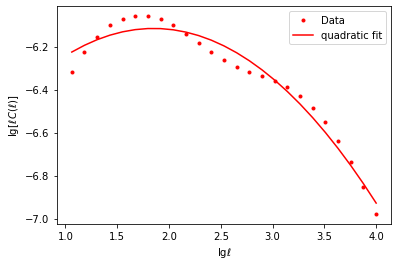

In [18]:
plot_1 = plt.plot(logell, logCell + logell, 'r.', label='Data')
plt.plot(logell, quadratic(logell, *popt), 'r-', label='quadratic fit')
plt.legend()
xl_1   = plt.xlabel('$\lg \ell$')
yl_1   = plt.ylabel('$\lg [\ell \, C(\ell)]$')

### Fit standard power spectrum with higher amplitude (small-scale normalization $\sigma_8$)

The normalisation is increased by 10%, thus $\sigma_8^+ = 0.9097$.

#### Fit by varying all coefficients

In [19]:
logell_ps, logCell_ps = read_Cell('{}/normalization+dp/P_kappa'.format(basedir), ell_min, ell_max)

In [20]:
p0 = [1, 0, 0]
popt_ps, pcov_ps = curve_fit(quadratic, logell_ps, logCell_ps + logell_ps, p0)

In [21]:
popt_ps

array([ 0.9254462 ,  0.31677232, -0.18913766])

#### Fit by only varying amplitude

In [22]:
tilt_glob, a_glob  = popt[1], popt[2]
p0  = [1]
popt_ps_A, pcov_ps_A = curve_fit(quadratic_c, logell_ps, logCell_ps + logell_ps, p0)

Best-fit ampl

In [23]:
popt_ps_A

array([0.92487861])

### Fit standard power spectrum with higher matter density $\Omega_{\rm m}$ (tilt and amplitude parameter)

Increase by 10% gives $\Omega_{\rm m}^+ = 0.3366$.

#### Fit by varying all parameters

In [24]:
logell_pO, logCell_pO = read_Cell('{}/Omega_m+dp/P_kappa'.format(basedir), ell_min, ell_max)

In [25]:
p0 = [1, 0, 0]
popt_pO, pcov_pO = curve_fit(quadratic, logell_pO, logCell_pO + logell_pO, p0)

In [26]:
popt_pO

array([ 0.87065394,  0.32647783, -0.19338417])

#### Fit by varying only shift parameter

In [27]:
ampl_glob, a_glob  = popt[0], popt[2]
p0  = [0]
popt_pO_x0, pcov_pO_x0 = curve_fit(quadratic_u0, logell_pO, logCell_pO + logell_pO, p0)

In [28]:
popt_pO_x0

array([0.326074])

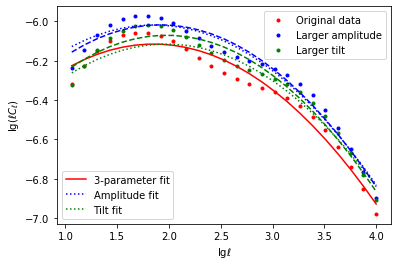

In [29]:
d1, = plt.plot(logell, logCell + logell, 'r.')
d2, = plt.plot(logell_ps, logCell_ps + logell, 'b.')
d3, = plt.plot(logell_pO, logCell_pO + logell, 'g.')

f1, = plt.plot(logell, quadratic(logell, *popt), 'r-')
f2, = plt.plot(logell_ps, quadratic_c(logell_ps, *popt_ps_A), 'b:')
f3, = plt.plot(logell_pO, quadratic_u0(logell_pO, *popt_pO_x0), 'g:')

plt.plot(logell_ps, quadratic(logell_ps, *popt_ps), 'b--')
plt.plot(logell_pO, quadratic(logell_pO, *popt_pO), 'g--')

plot_data  = [d1, d2, d3]
label_data = ['Original data', 'Larger amplitude', 'Larger tilt']
leg_data   = plt.legend(plot_data, label_data, loc=1)

plot_fit  = [f1, f2, f3]
label_fit = ['3-parameter fit', 'Amplitude fit', 'Tilt fit']
leg_fit   = plt.legend(plot_fit, label_fit, loc=3)

plt.gca().add_artist(leg_data)

text_x = plt.xlabel('$\lg \ell$')
text_y = plt.ylabel('$\lg(\ell C_\ell)$')

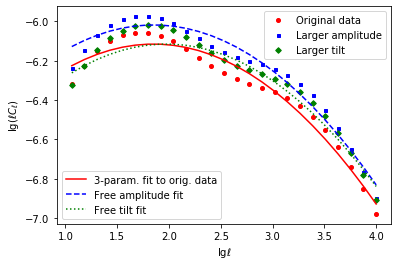

In [31]:
msize = 8
d1, = plt.plot(logell, logCell + logell, 'r.', markersize=msize)
d2, = plt.plot(logell_ps, logCell_ps + logell, 'bs', markersize=msize-5)
d3, = plt.plot(logell_pO, logCell_pO + logell, 'gD', markersize=msize-4)

f1, = plt.plot(logell, quadratic(logell, *popt), 'r-')
f2, = plt.plot(logell_ps, quadratic_c(logell_ps, *popt_ps_A), 'b--')
f3, = plt.plot(logell_pO, quadratic_u0(logell_pO, *popt_pO_x0), 'g:')

#plt.plot(logell_ps, quadratic(logell_ps, *popt_ps), 'b--')
#plt.plot(logell_pO, quadratic(logell_pO, *popt_pO), 'g--')

plot_data  = [d1, d2, d3]
label_data = ['Original data', 'Larger amplitude', 'Larger tilt']
leg_data   = plt.legend(plot_data, label_data, loc=1)

plot_fit  = [f1, f2, f3]
label_fit = ['3-param. fit to orig. data', 'Free amplitude fit', 'Free tilt fit']
leg_fit   = plt.legend(plot_fit, label_fit, loc=3)

plt.gca().add_artist(leg_data)

text_x = plt.xlabel('$\lg \ell$')
text_y = plt.ylabel('$\lg(\ell C_\ell)$')

### Covariance

#### Parameter and constants

In [30]:
from astropy import units
sigma_eps  = 0.22
nbar       = 30
nbar_amin2 = units.Unit('{}/arcmin**2'.format(nbar))
nbar_rad2  = nbar_amin2.to('1/rad**2')
f_sky           = 0.3636

#### Total power spectrum, including shot-/shape-noise term

In [31]:
C_ell_tot = 10**logCell + sigma_eps**2 / (2 * nbar_rad2)

In [32]:
ell = 10**logell

#### Bin width $\Delta_\ell$ when $\ell$ are logarithmic, and thus $\Delta \ln \ell = \Delta \ell / \ell$ = const

In [33]:
Delta_ln_ell = np.diff(ell) / (ell[:-1]/2 + ell[1:]/2)
Delta_ln_ell = np.append(Delta_ln_ell, Delta_ln_ell[-1])
Delta_ell = Delta_ln_ell * ell
Delta_ln_ell_bar = Delta_ln_ell.mean()

#### Gaussian covariance

In [68]:
D = 1.0 / (f_sky * (2.0 * ell + 1) * Delta_ln_ell_bar * ell) * C_ell_tot**2
D

array([  6.17732573e-17,   3.09827823e-17,   1.41512179e-17,
         5.84805529e-18,   2.19010601e-18,   7.54549084e-19,
         2.44292071e-19,   7.51585961e-20,   2.16726452e-20,
         5.85113927e-21,   1.56240752e-21,   4.25350205e-22,
         1.19023612e-22,   3.48116579e-23,   1.05938119e-23,
         3.31184406e-24,   1.04799770e-24,   3.32223412e-25,
         1.05395456e-25,   3.38222082e-26,   1.12250068e-26,
         3.96520026e-27,   1.52965640e-27,   6.51855737e-28,
         3.04663399e-28])

#### Approximation of $D$

In [35]:
A = 1/(2 * f_sky * Delta_ln_ell_bar)
B = sigma_eps**2 / (2 * nbar_rad2)
D2 = A / ell**2 * (10**quadratic(logell, *popt) / ell + B)**2

#### Read from file, created by ABC run

In [55]:
Dinv = np.loadtxt('cov_true_inv_diag.txt')

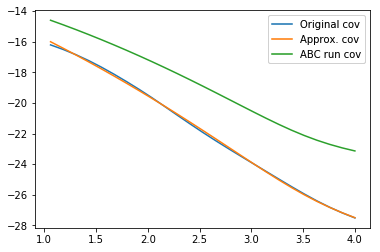

In [57]:
d1, = plt.plot(logell, np.log10(D))
d2, = plt.plot(logell, np.log10(D2))
d3, = plt.plot(logell, np.log10(1/Dinv))

plot_data  = [d1, d2, d3]
label_data = ['Original cov', 'Approx. cov', 'ABC run cov']
leg_data   = plt.legend(plot_data, label_data, loc=1)

leg = plt.gca().add_artist(leg_data)

In [70]:
D2

array([  9.91636845e-17,   3.71198276e-17,   1.35642479e-17,
         4.83896306e-18,   1.68545860e-18,   5.73262161e-19,
         1.90434141e-19,   6.18042435e-20,   1.96045260e-20,
         6.08171485e-21,   1.84680228e-21,   5.49700411e-22,
         1.60697946e-22,   4.62769000e-23,   1.31854896e-23,
         3.74103812e-24,   1.06666345e-24,   3.09494339e-25,
         9.28709234e-26,   2.93683769e-26,   9.97237242e-27,
         3.68877883e-27,   1.49500665e-27,   6.60934683e-28,
         3.14764833e-28])

In [71]:
popt

array([ 0.82708472,  0.306     , -0.17586216])

In [40]:
B = sigma_eps**2 / (2 * nbar_rad2) 

In [77]:
5000. / (np.pi*4 * 180**2 / np.pi**2)

0.121203420277384